# Logistic regression and the (adaptive) first-order optimizers

In this notebook, we study how different optimization algorithms update parameters
and how these update rules influence convergence and robustness.

We focus on:
- SGD
- Momentum
- Nesterov Accelerated Gradient (NAG)
- AdaGrad
- Adam

All methods are applied to **regularized logistic regression** on an ill-conditioned
synthetic dataset.

Key questions:
- How do update rules differ mathematically?
- How do adaptive methods implicitly precondition gradients?
- How does noise interact with these update mechanisms?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs("csv_synthetic", exist_ok=True)

# Quick knob
FAST_MODE = True
EPOCHS = 2000 if FAST_MODE else 5000

## 2. Synthetic logistic regression problem

We generate a binary classification dataset with:
- Gaussian features
- Strong feature-wise scaling (ill-conditioning)
- Logistic link function

This setup mimics real ML problems where different parameters
have vastly different sensitivities.

In [2]:
def make_synthetic_logistic(n=5000, d=40, seed=0):
    rng = np.random.default_rng(seed)

    X = rng.normal(size=(n, d))
    scales = np.logspace(0, 3, d)      # feature anisotropy
    X = X * scales

    w_true = rng.normal(size=d)
    logits = X @ w_true
    p = 1.0 / (1.0 + np.exp(-logits))
    y = rng.binomial(1, p)

    return X.astype(np.float64), y.astype(np.int32), w_true


X, y, _ = make_synthetic_logistic(n=6000, d=20, seed=0)
print("X shape:", X.shape, "| class balance:", y.mean())

X shape: (6000, 20) | class balance: 0.49266666666666664


/var/folders/pv/7xq94jdd4d51wrjpm4h32qj00000gn/T/ipykernel_30183/519591809.py:10: RuntimeWarning: overflow encountered in exp
  p = 1.0 / (1.0 + np.exp(-logits))


## 3. Logistic regression objective

We minimize the regularized logistic loss:
\[
f(w) = \frac{1}{n}\sum_{i=1}^n \ell(x_i^\top w, y_i)
+ \frac{\lambda}{2}\|w\|^2,
\]
where:
\[
\ell(z,y) = -y\log \sigma(z) - (1-y)\log(1-\sigma(z)).
\]

We explicitly implement:
- sigmoid (numerically stable)
- loss
- gradient

In [3]:
def sigmoid(z):
    z = z.astype(np.float64, copy=False)
    out = np.empty_like(z, dtype=np.float64)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out


def logloss(w, X, y, lam=1e-4):
    z = X @ w
    p = sigmoid(z)
    eps = 1e-12
    loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
    loss += 0.5 * lam * np.sum(w**2)
    return float(loss)


def grad_logloss(w, X, y, lam=1e-4):
    z = X @ w
    p = sigmoid(z)
    grad = (X.T @ (p - y)) / X.shape[0]
    grad += lam * w
    return grad

## 4. Reference optimum

To measure suboptimality, we compare against a reference value
\( f^\* \) obtained by a high-accuracy Newton solve.

For teaching purposes, we use a precomputed value.

In [4]:
# Fast option: use precomputed f_opt
f_opt = 1.101595433540e-03
print("Using precomputed f_opt =", f_opt)


def newton_solve_opt(X, y, lam=1e-4, tol=1e-10, max_iter=50):
    d = X.shape[1]
    w = np.zeros(d)

    for it in range(max_iter):
        g = grad_logloss(w, X, y, lam)
        ng = np.linalg.norm(g)
        if ng < tol:
            print(f"[Newton] Converged in {it} iterations | ||g||={ng:.2e}")
            break

        H = hess_logloss_full(w, X, y, lam)
        step = np.linalg.solve(H, g)
        w = w - step

    f_star = logloss(w, X, y, lam)
    print(f"[Newton] f* = {f_star:.12e}")
    return w, f_star

# Uncomment to recompute  f_opt (slow, but nexessary if data, or reg. parameter changes)
# w_star, f_opt = newton_solve_opt(X, y, lam=LAMBDA)

Using precomputed f_opt = 0.00110159543354


## 5. Optimizer update rules (theory)

Let $ g_k = \nabla f(w_k) $.

### SGD
$w_{k+1} = w_k - \eta g_k$

### Momentum
$$
v_{k+1} = \beta v_k + g_k,
\qquad
w_{k+1} = w_k - \eta v_{k+1}
$$

Momentum averages gradients over time, damping oscillations.

### Nesterov Accelerated Gradient (NAG)
$$
g_k = \nabla f(w_k - \eta\beta v_k), \quad
v_{k+1} = \beta v_k + g_k
$$

NAG evaluates gradients at a *lookahead* point.

### AdaGrad
$$
H_k = \sum_{i=1}^k g_i^2, \quad
w_{k+1} = w_k - \eta \frac{g_k}{\sqrt{H_k} + \varepsilon}
$$

AdaGrad applies coordinate-wise step-size adaptation.

### Adam
$$
m_k = \beta_1 m_{k-1} + (1-\beta_1)g_k,\quad
v_k = \beta_2 v_{k-1} + (1-\beta_2)g_k^2
$$
with bias correction.

Adam combines momentum and adaptive scaling.

## 6. Unified optimizer runner

We implement a single driver that:
- supports multiple optimizers
- tracks per-epoch loss, suboptimality, and direction variance
- allows fair comparison under identical conditions

In [ ]:
def run_optimizer(
    X, y, lam=1e-4,
    epochs=300, batch_size=16,
    optimizer="sgd",
    eta0=1e-3,
    beta=0.9,
    beta1=0.9, beta2=0.999,
    eps=1e-8,
    seed=0, f_opt=None
):

    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)

    # State variables
    v = np.zeros_like(w)        # momentum velocity
    m = np.zeros_like(w)        # first moment (Adam / AdaGrad)
    v2 = np.zeros_like(w)       # second moment (Adam)

    hist = {
        "epoch": [],
        "loss": [],
        "subopt": [],
        "dir_var": [],
        "optimizer": []
    }

    for ep in range(epochs):
        idx = rng.permutation(n)
        Xs, ys = X[idx], y[idx]

        dirs = []   # store update directions within the epoch

        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            Xb, yb = Xs[start:end], ys[start:end]

            g = grad_logloss(w, Xb, yb, lam)

            if optimizer == "SGD":
                d = -eta0 * g

            elif optimizer == "momentum":
                v = beta * v + g
                d = -eta0 * v

            elif optimizer == "NAG":
                w_look = w - eta0 * beta * v
                g = grad_logloss(w_look, Xb, yb, lam)
                v = beta * v + g
                d = -eta0 * v

            elif optimizer == "AdaGrad":
                m += g * g
                d = -eta0 * g / (np.sqrt(m) + eps)

            elif optimizer == "Adam":
                m = beta1 * m + (1 - beta1) * g
                v2 = beta2 * v2 + (1 - beta2) * (g * g)
                m_hat = m / (1 - beta1 ** (ep + 1))
                v_hat = v2 / (1 - beta2 ** (ep + 1))
                d = -eta0 * m_hat / (np.sqrt(v_hat) + eps)

            else:
                raise ValueError("Unknown optimizer")

            dirs.append(d)
            w += d

        # Epoch-level statistics
        f = logloss(w, X, y, lam)
        hist["epoch"].append(ep)
        hist["loss"].append(f)
        hist["subopt"].append(f - f_opt)
        hist["optimizer"].append(optimizer)


    return hist

## 7. Experiment: comparing optimizers

We compare optimizers in the *full-batch* regime to isolate
the effect of update rules rather than sampling noise.

In [10]:
optimizers = ["SGD", "NAG", "AdaGrad", "Adam"]
lr_rates = [1e-4, 1e-4, 1e-2, 1e-2]

histories = {}

for opt, lr in zip(optimizers, lr_rates):
    print(f"Running {opt} with lr={lr}")
    h = run_optimizer(
        X, y,
        epochs=EPOCHS,
        batch_size=X.shape[0],
        eta0=lr,
        optimizer=opt,
        f_opt=f_opt
    )
    histories[opt] = h


Running SGD with lr=0.0001
Running NAG with lr=0.0001
Running AdaGrad with lr=0.01
Running Adam with lr=0.01


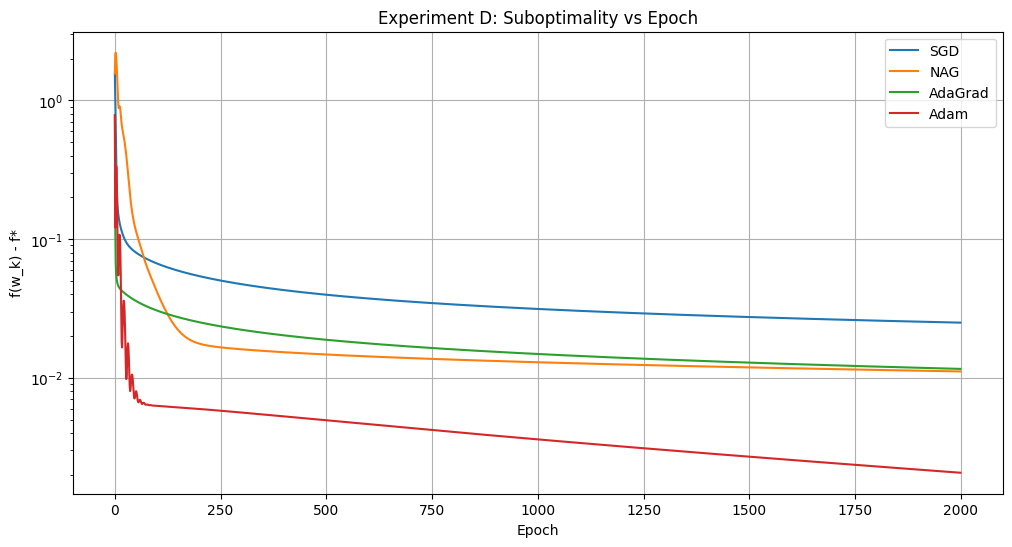

In [ ]:
plt.figure(figsize=(12,6))

for opt in optimizers:
    h = histories[opt]
    plt.semilogy(h["epoch"], h["subopt"], label=opt)

plt.title("Suboptimality vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("f(w_k) - f*")
plt.grid(True)
plt.legend()
plt.show()

## Interpretation

- **SGD** struggles on ill-conditioned problems.
- **Momentum / NAG** smooth oscillations but do not fully correct anisotropy.
- **AdaGrad** rescales coordinates but may stall due to aggressive decay.
- **Adam** combines momentum and adaptive scaling, leading to robust performance.

### Key insight
Adaptive methods implicitly apply **diagonal preconditioning**, which partially
approximates second-order curvature information and speeds-up convergence.